In [1]:
!pip install bayesian-optimization==1.4.1

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score,recall_score,confusion_matrix, roc_curve, auc,f1_score,accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV,cross_val_score, KFold, GridSearchCV
from bayes_opt import BayesianOptimization

In [3]:
#Loading and viewing the data
df = pd.read_csv("german_credit_data.csv")
df = df.drop(columns=["Unnamed: 0"],axis=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
#Descriptive stats about the data
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [5]:
#Checking and Filling Null Values
print(df.isnull().sum(axis=0))
df = df.fillna('No Account')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [6]:
#Checking for the uniqe values in the categorical columns
categorical = ["Sex","Job","Housing","Saving accounts","Checking account","Purpose","Risk"]
for column in categorical:
    unique_values = df[column].unique()
    print(f'Unique values in column {column}: {unique_values}')

Unique values in column Sex: ['male' 'female']
Unique values in column Job: [2 1 3 0]
Unique values in column Housing: ['own' 'free' 'rent']
Unique values in column Saving accounts: ['No Account' 'little' 'quite rich' 'rich' 'moderate']
Unique values in column Checking account: ['little' 'moderate' 'No Account' 'rich']
Unique values in column Purpose: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Unique values in column Risk: ['good' 'bad']


Univariate Analysis

In [7]:
#Count Plots for Categorical Variables
def count(column,rot=0):
    counts = df[column].value_counts().sort_values(ascending=False)
    sns.countplot(x=column,data=df, order=counts.index)
    plt.xlabel(f"{column}")
    plt.ylabel("Frequenecy of Occurence")
    plt.title(f"Countplot for {column}")
    plt.xticks(rotation=rot)
    plt.show()
    print(counts)

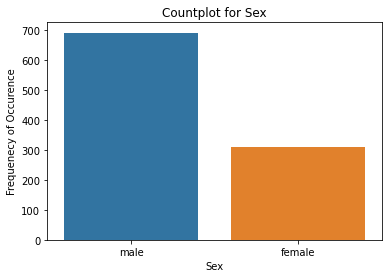

male      690
female    310
Name: Sex, dtype: int64


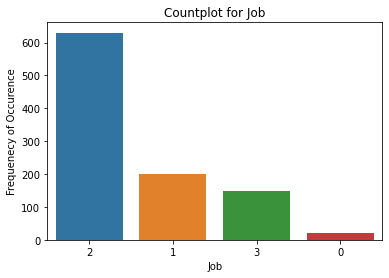

2    630
1    200
3    148
0     22
Name: Job, dtype: int64


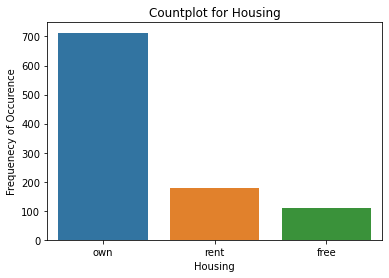

own     713
rent    179
free    108
Name: Housing, dtype: int64


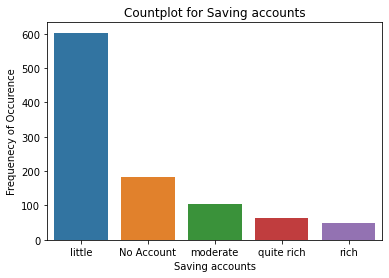

little        603
No Account    183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64


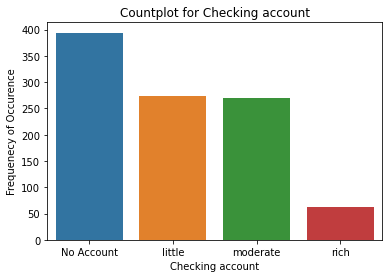

No Account    394
little        274
moderate      269
rich           63
Name: Checking account, dtype: int64


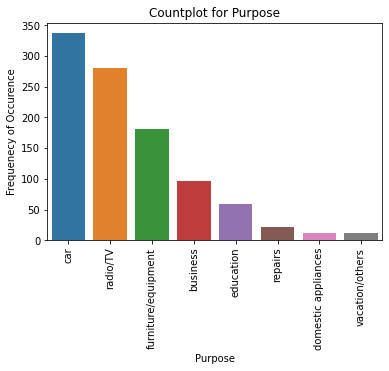

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64


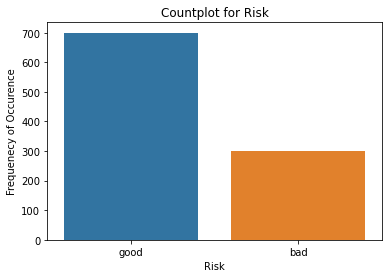

good    700
bad     300
Name: Risk, dtype: int64


In [8]:
for column in categorical:
    if column=="Purpose":
        count(column,90)
    else:
        count(column)

These plots provide a distribution of the different classes and the target feature. Since the number of good credits are 70% of the dataset, we say that we have an imbalanced dataset.

In [9]:
#Function for plotting distribution of continous features
def hist(column,bins=20):
    sns.histplot(x=column,data=df,bins=bins, color='deepskyblue',kde=True)
    plt.show()

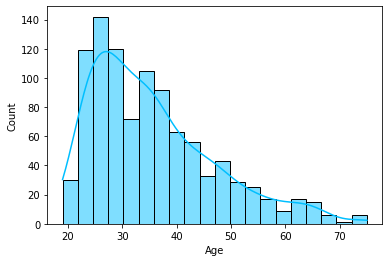

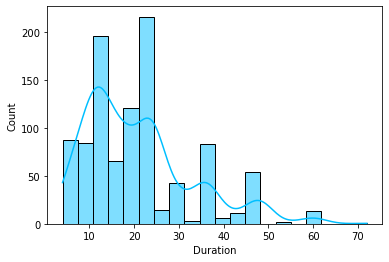

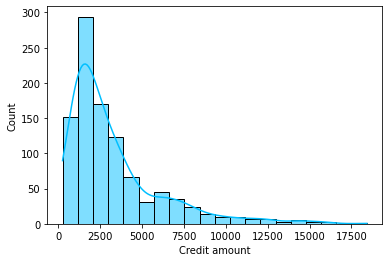

In [10]:
num_columns = ["Age","Duration","Credit amount"]
for column in num_columns:
    hist(column)

We see that all three distribtuions have a right skew

Bivariate Analysis

In [11]:
#Checking the various categorical columns while comparing with target class
def bivariate(column,rot=0):
    sns.countplot(x=column, hue="Risk", data=df)
    plt.xticks(rotation=rot)
    plt.show()
    for cat in df[column].unique():
        x = len(df[(df[col]==cat) & (df['Risk']=='bad')])/len(df[(df[col]==cat)])*100
        print(f"Percentage of {cat} with Bad Loans: {x:.2f}%")

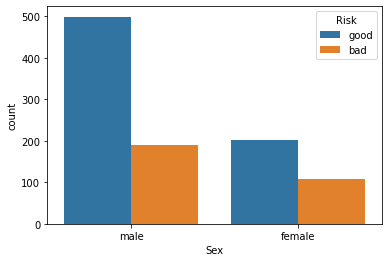

Percentage of male with Bad Loans: 27.68%
Percentage of female with Bad Loans: 35.16%


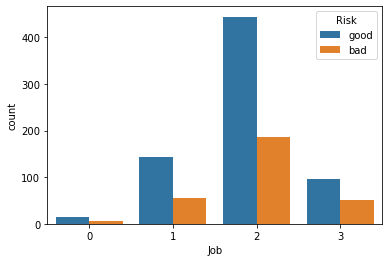

Percentage of 2 with Bad Loans: 29.52%
Percentage of 1 with Bad Loans: 28.00%
Percentage of 3 with Bad Loans: 34.46%
Percentage of 0 with Bad Loans: 31.82%


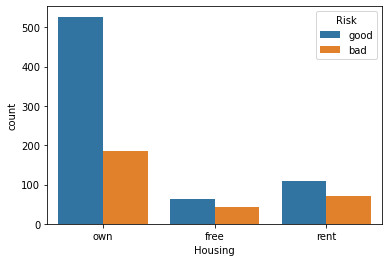

Percentage of own with Bad Loans: 26.09%
Percentage of free with Bad Loans: 40.74%
Percentage of rent with Bad Loans: 39.11%


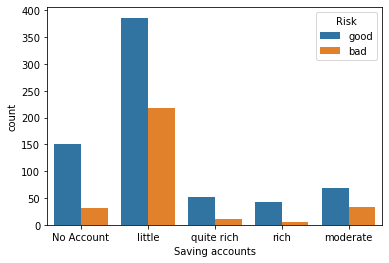

Percentage of No Account with Bad Loans: 17.49%
Percentage of little with Bad Loans: 35.99%
Percentage of quite rich with Bad Loans: 17.46%
Percentage of rich with Bad Loans: 12.50%
Percentage of moderate with Bad Loans: 33.01%


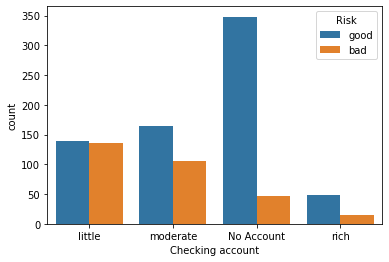

Percentage of little with Bad Loans: 49.27%
Percentage of moderate with Bad Loans: 39.03%
Percentage of No Account with Bad Loans: 11.68%
Percentage of rich with Bad Loans: 22.22%


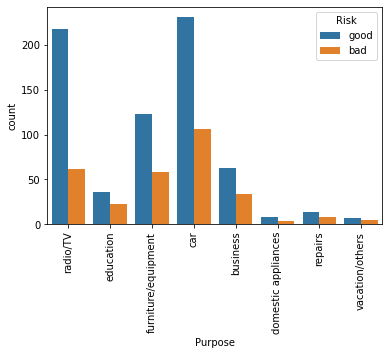

Percentage of radio/TV with Bad Loans: 22.14%
Percentage of education with Bad Loans: 38.98%
Percentage of furniture/equipment with Bad Loans: 32.04%
Percentage of car with Bad Loans: 31.45%
Percentage of business with Bad Loans: 35.05%
Percentage of domestic appliances with Bad Loans: 33.33%
Percentage of repairs with Bad Loans: 36.36%
Percentage of vacation/others with Bad Loans: 41.67%


In [12]:
for col in categorical:
    if col == "Risk":
        pass
    elif col == "Purpose":
        bivariate(col,90)
    else:
        bivariate(col)

<AxesSubplot:xlabel='Credit amount', ylabel='Purpose'>

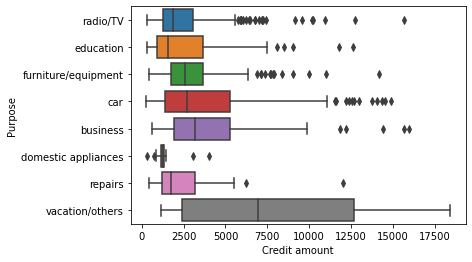

In [13]:
sns.boxplot(y="Purpose",x="Credit amount",data=df)

In [14]:
#Here we analyse the outliers of the credit amount wrt to the categories in the purpose feature
def outlier_analysis(cat):
    df_a = df["Credit amount"].loc[df["Purpose"]==cat]
    out_l = df_a.quantile(0.75) + 1.5*(df_a.quantile(0.75) - df_a.quantile(0.25))
    df_b = df[(df["Purpose"]==cat) & (df["Credit amount"]>out_l)]
    display(df_b)
    percent = len(df_b.loc[df_b["Risk"]=="bad"])*100/len(df_b)
    print(f"Percentage of Bad Loans for {cat} where the credit amount lies in the oulier range: {percent:.2f}%")

In [15]:
outlier_analysis("radio/TV")

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
56,52,male,3,own,No Account,moderate,6468,12,radio/TV,bad
57,31,female,2,own,little,No Account,9566,36,radio/TV,good
80,44,female,2,own,No Account,No Account,5943,24,radio/TV,bad
116,30,female,3,own,No Account,little,7174,42,radio/TV,bad
134,21,female,2,own,moderate,No Account,10144,60,radio/TV,good
152,24,male,2,own,little,rich,5848,36,radio/TV,good
226,27,male,2,own,rich,moderate,10961,48,radio/TV,bad
255,27,male,1,own,No Account,moderate,7418,60,radio/TV,good
353,28,male,2,rent,little,little,6199,12,radio/TV,bad


Percentage of Bad Loans for radio/TV where the credit amount lies in the oulier range: 34.78%


In [16]:
outlier_analysis("car")

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
18,44,female,3,free,little,moderate,12579,24,car,bad
236,23,male,0,own,No Account,moderate,14555,6,car,bad
272,36,male,3,free,No Account,moderate,12169,48,car,good
333,24,female,1,rent,moderate,No Account,11590,48,car,bad
373,63,male,3,free,No Account,No Account,13756,60,car,good
378,57,male,3,free,little,moderate,14318,36,car,bad
381,38,female,3,free,little,moderate,12976,18,car,bad
563,37,male,2,free,No Account,moderate,12389,36,car,bad
714,27,male,3,own,little,moderate,14027,60,car,bad
736,23,female,3,rent,little,moderate,11560,24,car,bad


Percentage of Bad Loans for car where the credit amount lies in the oulier range: 83.33%


In [17]:
outlier_analysis("furniture/equipment")

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
108,30,female,2,own,No Account,little,7721,24,furniture/equipment,good
227,53,male,3,free,little,little,7865,12,furniture/equipment,bad
295,26,female,2,own,little,moderate,9960,48,furniture/equipment,bad
387,40,male,3,own,little,moderate,7374,18,furniture/equipment,good
496,29,male,3,rent,moderate,moderate,9034,36,furniture/equipment,bad
517,23,female,2,rent,little,No Account,7127,36,furniture/equipment,bad
522,53,male,2,free,little,little,7119,48,furniture/equipment,bad
744,30,male,3,own,No Account,little,14179,39,furniture/equipment,good
870,40,female,2,own,quite rich,No Account,7678,36,furniture/equipment,good


Percentage of Bad Loans for furniture/equipment where the credit amount lies in the oulier range: 61.54%


From this we can see when people take credit amount which lies in the outlier range or which is more than normal for certain purpose like purchasing cars or furniture/equipment the deafult rates shoots up to 60-80% while for some purposes like purcahsing radio/TV or education remains alomst same.

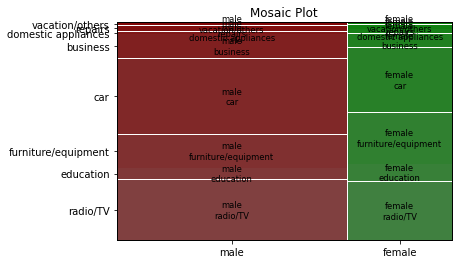

In [18]:
#Mosiac plot to see what purpose do each gender takes loan for
mosaic(df, ['Sex', 'Purpose'], title='Mosaic Plot')
plt.show()

Feature Engineering

C:\Users\2216027\AppData\Local\Temp\ipykernel_54396\1331420377.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<AxesSubplot:>

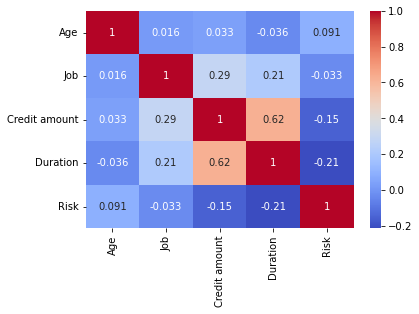

In [19]:
#Replace good/bad with 0/1
df['Risk'] = df['Risk'].replace({'bad': 0, 'good': 1})
#Correlation Matrix for Continous Variables
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

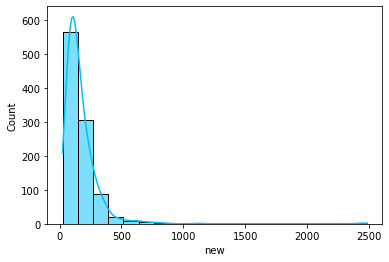

In [20]:
#Trying to build a new variable which combines credit amount and duration as they are highly correlated
df['new'] = df['Credit amount']/df["Duration"]
hist('new')

C:\Users\2216027\AppData\Local\Temp\ipykernel_54396\2297058646.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<AxesSubplot:>

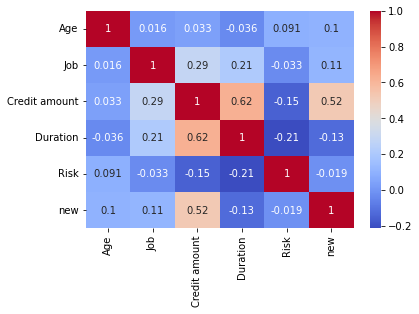

In [21]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

In [22]:
#Chi-Squared test to find if correlation is present b/w target and categorical features
def target_corr(col):
    contingency_table = pd.crosstab(df['Risk'], df[col])
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)
    if(p_value>0.05):
        print(f"No correlation b/w the target variable and {col}")
    else:
        print(f"Significant correlation b/w target and {col}")
        print(p_value)

In [24]:
#Results for different features
for col in categorical:
    if col == "Risk":
        pass
    else:
        target_corr(col)

Significant correlation b/w target and Sex
0.020739913068713305
No correlation b/w the target variable and Job
Significant correlation b/w target and Housing
0.00011167465374597686
Significant correlation b/w target and Saving accounts
2.761214238568249e-07
Significant correlation b/w target and Checking account
1.2189020722893755e-26
No correlation b/w the target variable and Purpose


In [25]:
#Chi-Squared Test to find corrlation b/w independent categorical features
def multi_corr(col1,col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)
    if(p_value>0.05):
        print(f"No correlation b/w the {col1} and {col2}")
    else:
        print(f"Significant correlation {col1} and {col2}")

In [26]:
#Results
multi_corr('Sex','Housing')
multi_corr('Housing','Checking account')
multi_corr('Housing','Saving accounts')
multi_corr("Saving accounts","Checking account")
multi_corr('Sex','Checking account')

Significant correlation Sex and Housing
Significant correlation Housing and Checking account
No correlation b/w the Housing and Saving accounts
Significant correlation Saving accounts and Checking account
No correlation b/w the Sex and Checking account


In [27]:
#One-Hot Encoding the Sex and Checking Account
one_hot = pd.get_dummies(df, columns=['Sex', 'Checking account'])

In [28]:
#Dropping columns which are not correlated with target or significantly correlated with some other feature
one_hot = one_hot.drop(['Housing', 'Purpose', 
'Saving accounts','new'], axis=1)
#Log Transforming the continous variables
one_hot['Duration'] = np.log(one_hot['Duration'])
one_hot['Credit amount'] = np.log(one_hot['Credit amount'])
one_hot['Age'] = np.log(one_hot['Age'])

In [29]:
one_hot.head()

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Checking account_No Account,Checking account_little,Checking account_moderate,Checking account_rich
0,4.204693,2,7.063904,1.791759,1,0,1,0,1,0,0
1,3.091042,2,8.691315,3.871201,0,1,0,0,0,1,0
2,3.891820,1,7.647786,2.484907,1,0,1,1,0,0,0
3,3.806662,2,8.972337,3.737670,1,0,1,0,1,0,0
4,3.970292,2,8.490849,3.178054,0,0,1,0,1,0,0


In [31]:
one_hot.describe()

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Checking account_No Account,Checking account_little,Checking account_moderate,Checking account_rich
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.524306,1.904000,7.788691,2.877018,0.700000,0.310000,0.690000,0.394000,0.274000,0.269000,0.063000
std,0.299747,0.653614,0.776474,0.582240,0.458487,0.462725,0.462725,0.488879,0.446232,0.443662,0.243085
min,2.944439,0.000000,5.521461,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.295837,2.000000,7.219276,2.484907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.496508,2.000000,7.749107,2.890372,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3.737670,2.000000,8.287088,3.178054,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,4.317488,3.000000,9.821409,4.276666,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Modelling

In [32]:
# Splitting the features and target vector
one_hot = one_hot.reindex(columns=[col for col in one_hot.columns if col != 'Risk'] + ['Risk'])
X = one_hot.iloc[:,:-1]
y = one_hot.iloc[:,-1]

In [33]:
#Oversampling using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=4)

Random Forest

In [34]:
#Objective Function
def objective(n_estimators, min_samples_split,min_samples_leaf):
    clf = RandomForestClassifier(n_estimators=int(n_estimators), 
                                 min_samples_split=int(min_samples_split),
                                 min_samples_leaf=int(min_samples_leaf),
                                 random_state=42)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='f1').mean()
    return score

# Set the ranges of hyperparameters to optimize
pbounds = {'n_estimators': (50, 200),
           'min_samples_split': (2, 10),
           'min_samples_leaf': (1,5)}

# Define the Bayesian Optimization object
optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)

# Run the optimization process
optimizer.maximize(init_points=5, n_iter=20)

# Print the best hyperparameters and score found
print('Best score:', optimizer.max['target'])
print('Best parameters:', optimizer.max['params'])

|   iter    |  target   | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.7274    | 2.498     | 9.606     | 159.8     |
| 2         | 0.7299    | 3.395     | 3.248     | 73.4      |
| 3         | 0.7314    | 1.232     | 8.929     | 140.2     |
| 4         | 0.7258    | 3.832     | 2.165     | 195.5     |
| 5         | 0.7219    | 4.33      | 3.699     | 77.27     |
| 6         | 0.7334    | 1.255     | 8.651     | 139.8     |
| 7         | 0.7349    | 1.092     | 8.572     | 138.6     |
| 8         | 0.7382    | 1.565     | 6.829     | 139.0     |
| 9         | 0.7253    | 4.224     | 6.571     | 138.4     |
| 10        | 0.7352    | 1.391     | 6.453     | 140.6     |
| 11        | 0.7489    | 1.06      | 4.736     | 137.4     |
| 12        | 0.7538    | 1.154     | 3.317     | 138.0     |
| 13        | 0.7506    | 1.0       | 2.0       | 136.1     |
| 14        | 0.7513    | 1.203     | 2.112     | 139.8     |
| 15    

In [35]:
#Model Performance on Test Set
params = optimizer.max['params']
n_estimators = int(params["n_estimators"])
min_samples_split = int(params["min_samples_split"])
min_samples_leaf = int(params["min_samples_leaf"])
model = RandomForestClassifier(n_estimators=int(n_estimators), 
                                 min_samples_split=int(min_samples_split),
                                 min_samples_leaf=int(min_samples_leaf),
                                 random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f"The accuracy for the test set is given as: {accuracy_score(y_test,y_pred):.2f}")
print(f"The F1-score for the test set is given as: {f1_score(y_test,y_pred):.2f}")
print(f"The precision score for the test set is given as: {precision_score(y_test,y_pred):.2f}")
print(f"The recall score for the test set is given as: {recall_score(y_test,y_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

The accuracy for the test set is given as: 0.84
The F1-score for the test set is given as: 0.83
The precision score for the test set is given as: 0.85
The recall score for the test set is given as: 0.82
Confusion Matrix:
[[118  21]
 [ 25 116]]


XGBoost

In [36]:
#Objective Function
def objective(learning_rate, n_estimators, max_depth, min_child_weight, subsample, colsample_bytree):
    clf = XGBClassifier(learning_rate=learning_rate,
                            n_estimators=int(n_estimators),
                            max_depth=int(max_depth),
                            min_child_weight=int(min_child_weight),
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            random_state=42,
                            n_jobs=-1)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='f1').mean()
    return score

# Set the ranges of hyperparameters to optimize
pbounds = {'learning_rate': (0.01, 0.3),
           'n_estimators': (50, 200),
           'max_depth': (3, 10),
           'min_child_weight': (1, 10),
           'subsample': (0.5, 1),
           'colsample_bytree': (0.5, 1)}

# Define the Bayesian Optimization object
optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)

# Run the optimization process
optimizer.maximize(init_points=5, n_iter=20)

# Print the best hyperparameters and score found
print('Best score:', optimizer.max['target'])
print('Best parameters:', optimizer.max['params'])

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.725     | 0.6873    | 0.2857    | 8.124     | 6.388     | 73.4      | 0.578     |
| 2         | 0.7319    | 0.529     | 0.2612    | 7.208     | 7.373     | 53.09     | 0.985     |
| 3         | 0.7146    | 0.9162    | 0.07158   | 4.273     | 2.651     | 95.64     | 0.7624    |
| 4         | 0.73      | 0.716     | 0.09446   | 7.283     | 2.255     | 93.82     | 0.6832    |
| 5         | 0.735     | 0.728     | 0.2377    | 4.398     | 5.628     | 138.9     | 0.5232    |
| 6         | 0.7248    | 0.5689    | 0.1875    | 4.166     | 5.758     | 138.5     | 0.649     |
| 7         | 0.7541    | 0.5621    | 0.2167    | 8.185     | 2.408     | 145.1     | 0.9424    |
| 8         | 0.7394    | 0.6052    | 0.2978    | 4.497     | 7.309     | 124.3     | 0.6438    |
| 9         | 0.7412

In [37]:
#Model Performance on Test Set
params = optimizer.max['params']
n_estimators = int(params["n_estimators"])
max_depth = int(params["max_depth"])
min_child_weight = int(params["min_child_weight"])
learning_rate = params["learning_rate"]
subsample = params["subsample"]
colsample_bytree= params["colsample_bytree"]
model = XGBClassifier(learning_rate=learning_rate,
                            n_estimators=int(n_estimators),
                            max_depth=int(max_depth),
                            min_child_weight=int(min_child_weight),
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            random_state=42,
                            n_jobs=-1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f"The accuracy for the test set is given as: {accuracy_score(y_test,y_pred):.2f}")
print(f"The F1-score for the test set is given as: {f1_score(y_test,y_pred):.2f}")
print(f"The precision score for the test set is given as: {precision_score(y_test,y_pred):.2f}")
print(f"The recall score for the test set is given as: {recall_score(y_test,y_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

The accuracy for the test set is given as: 0.84
The F1-score for the test set is given as: 0.84
The precision score for the test set is given as: 0.86
The recall score for the test set is given as: 0.81
Confusion Matrix:
[[121  18]
 [ 27 114]]
